In [41]:
import os
import numpy as np
import pandas as pd

import torch
from torchvision.datasets import MNIST
from captum.attr import GradientShap

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from lfxai.explanations.features import attribute_auxiliary
from lfxai.models.images import ClassifierMnist, EncoderMnist
import copy

from matplotlib import pyplot as plt

In [42]:
# Basic setup
torch.random.manual_seed(123)
batch_size = 128
device = 'cpu'

# Model Args
image_height = 28
dim_latent = 4

In [43]:
# Data loading
data_dir = "data/mnist"
shared_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(data_dir, train=True, download=True, transform=shared_transform
                                           )
test_dataset = MNIST(data_dir, train=False, download=True, transform=shared_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [44]:
#### Model loading ######
# Specification
dim_latent = 4
name = "TestClassifier"
classifier_state_dict_path = os.path.join('..', 'TrainedModels', 'MNIST', 'Classifier_run0.pt') # TODO Need to loop over runs

# Load
encoder = EncoderMnist(dim_latent)

classifier = ClassifierMnist(encoder, dim_latent, name)
classifier.load_state_dict(torch.load(classifier_state_dict_path), strict=True)

encoder = copy.deepcopy(classifier.encoder) # Necessary? Should check whether the load just modifies the original

print("Classifier Loaded")

Classifier Loaded
Classifier Loaded


In [45]:
# Instantiate GradShap For Encoder and Full Model
gradshap_encoder = GradientShap(encoder)
gradshap_full_model = GradientShap(classifier)


In [46]:
baseline_image = torch.zeros((1, 1, 28, 28), device=device)

In [47]:
encoder_attributions = attribute_auxiliary(
                        encoder, test_loader, device, gradshap_encoder, baseline_image
                    )

# Note that this is the correct thing to do here because the classifier outputs probabilities so we are taking a soft sum
pipeline_attributions = attribute_auxiliary(
    classifier, test_loader, device, gradshap_full_model, baseline_image
)



In [48]:
# Cast each one to absolute value, since we're not interested in the direction on the hidden space
encoder_attributions = np.abs(encoder_attributions)
pipeline_attributions = np.abs(pipeline_attributions)

# Normalise each one to have variance 1
encoder_attributions = encoder_attributions/np.std(encoder_attributions)
pipeline_attributions = pipeline_attributions/np.std(pipeline_attributions)


Text(0.5, 1.0, 'Classifier Saliency Map')

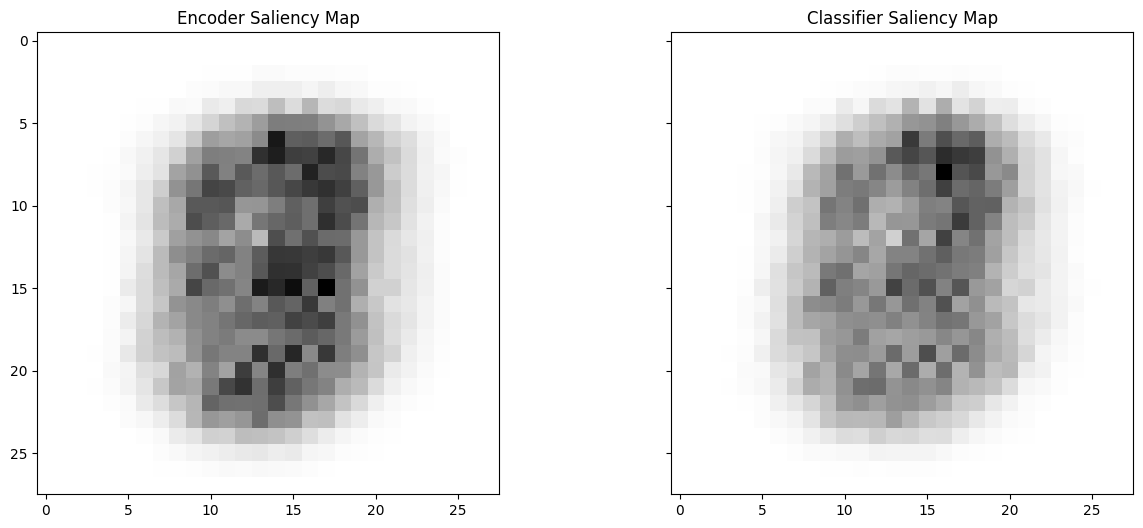

Text(0.5, 1.0, 'Classifier Saliency Map')

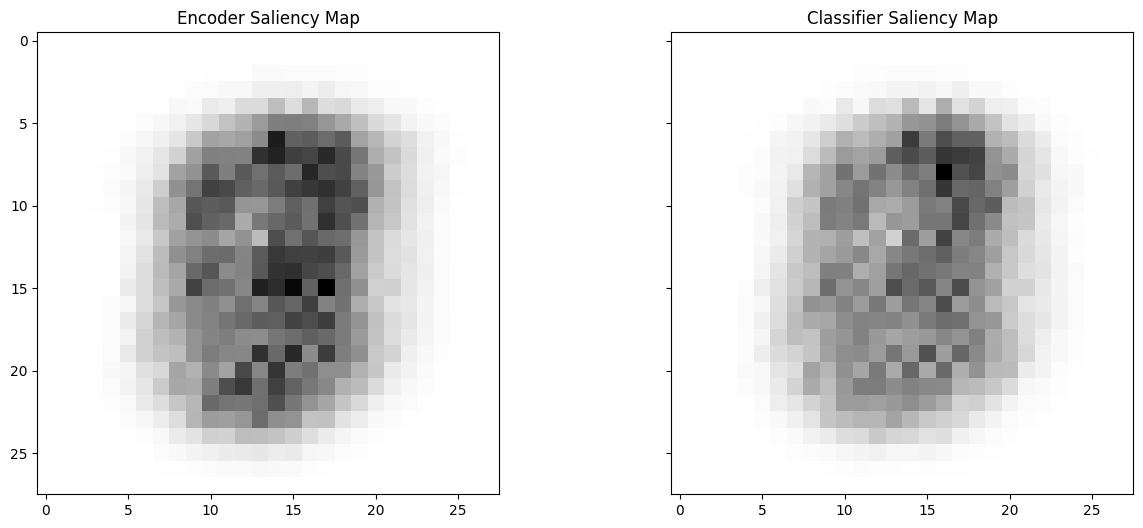

In [49]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=[15, 6])
ax[0].imshow(encoder_attributions.mean(axis=0).squeeze(), cmap='gray_r')
ax[0].set_title('Encoder Saliency Map')

ax[1].imshow(pipeline_attributions.mean(axis=0).squeeze(), cmap='gray_r')
ax[1].set_title('Classifier Saliency Map')

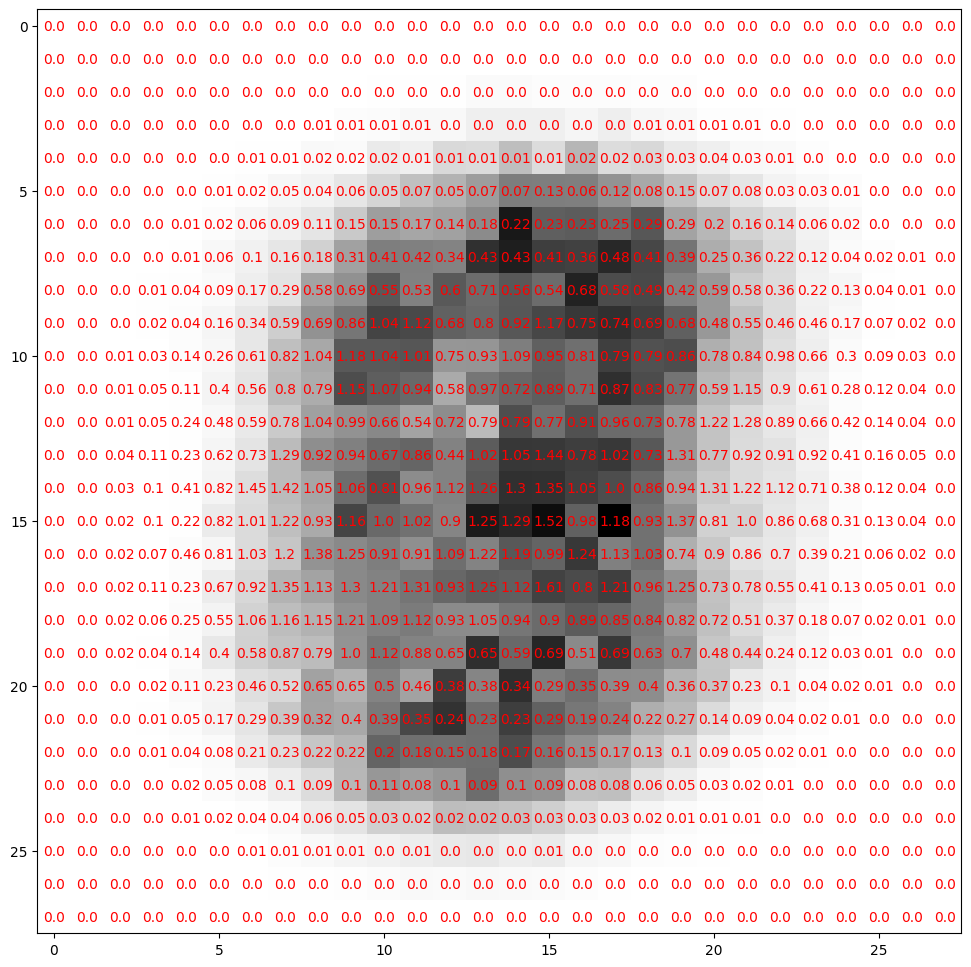

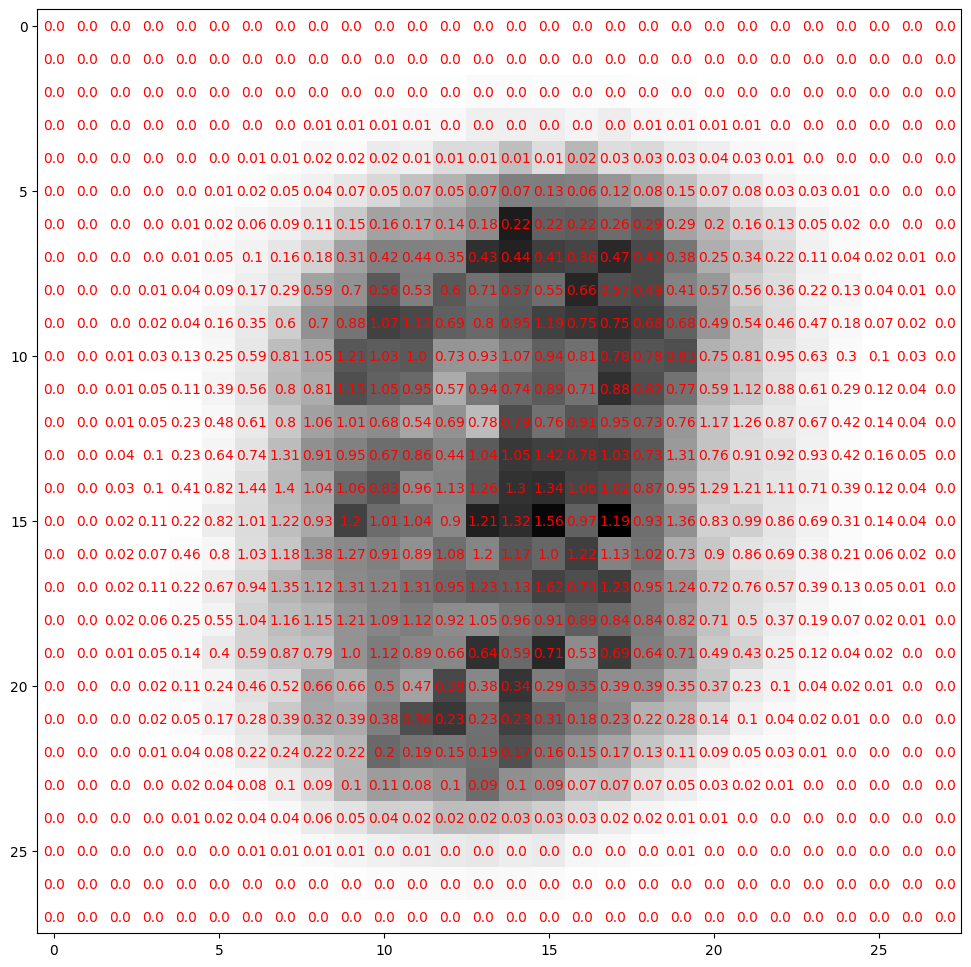

In [50]:
# As above, but shows more detail so that we can understand what's going on better
fig, ax = plt.subplots(figsize=[12, 12])
ax.imshow(encoder_attributions.mean(axis=0).squeeze(), cmap='gray_r')
for (i, j), pixel_value in np.ndenumerate(np.mean(encoder_attributions, axis=0).squeeze().round(2)):
    ax.text(i, j, pixel_value, c='red', ha='center',va='center')

In [51]:
# Compute the pearson correlation between the maps
# TODO we should also exclude constant/nearly constant pixels?

# Note there are a few ways we could possibly do this, e.g. taking the mean of the feature values first
# However, I think that unnecessarily discards structure that we might otherwise want to keep.
pearsons_rho = np.corrcoef(encoder_attributions.flatten(),
                           pipeline_attributions.flatten())
pearsons_rho

array([[1.        , 0.23466621],
       [0.23466621, 1.        ]])

array([[1.        , 0.23651764],
       [0.23651764, 1.        ]])

In [52]:
# Alternatively, we may want to consider the R**2 value. Assuming a linear relationship + intercept, this is just the
# Square of the pearson coefficient.
pearsons_rho**2

array([[1.        , 0.05506823],
       [0.05506823, 1.        ]])

array([[1.        , 0.05594059],
       [0.05594059, 1.        ]])

In [53]:
# Finally we can look at what happens when we first aggregate across the images
pearsons_rho_agg = np.corrcoef(encoder_attributions.mean(axis=0).flatten(), pipeline_attributions.mean(axis=0).flatten())
pearsons_rho_agg

array([[1.        , 0.98490064],
       [0.98490064, 1.        ]])

array([[1.        , 0.98445307],
       [0.98445307, 1.        ]])

(array([407.,  62.,  59.,  42.,  38.,  31.,  12.,  11.,   5.,   1.]),
 array([3.21865659e-11, 2.12844774e-01, 4.25689548e-01, 6.38534307e-01,
        8.51379097e-01, 1.06422389e+00, 1.27706861e+00, 1.48991346e+00,
        1.70275819e+00, 1.91560304e+00, 2.12844777e+00]),
 <BarContainer object of 10 artists>)

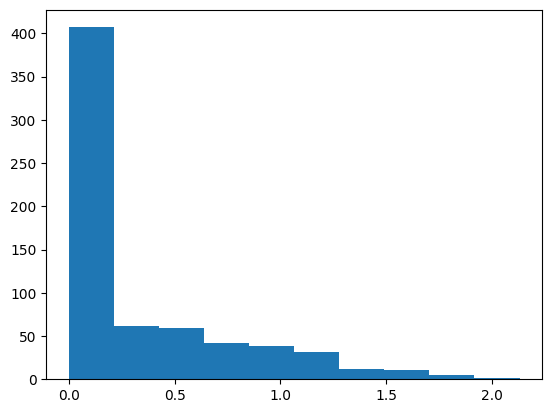

(array([408.,  66.,  52.,  53.,  41.,  23.,  12.,   9.,   3.,   1.]),
 array([4.88588392e-10, 2.21846789e-01, 4.43693578e-01, 6.65540397e-01,
        8.87387156e-01, 1.10923398e+00, 1.33108079e+00, 1.55292761e+00,
        1.77477431e+00, 1.99662113e+00, 2.21846795e+00]),
 <BarContainer object of 10 artists>)

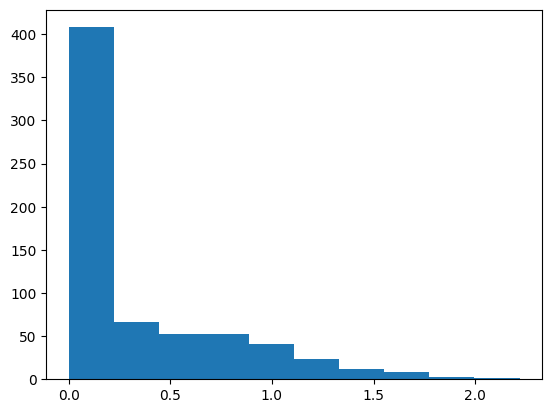

In [54]:
dots = (encoder_attributions*pipeline_attributions).mean(axis=0).squeeze()
dots = dots[np.abs(dots) > 0]

plt.hist(dots.flatten())

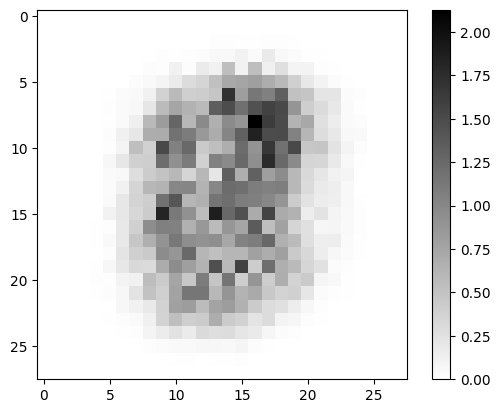

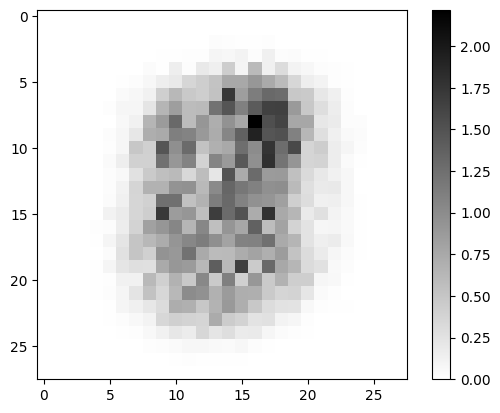

In [55]:
plt.imshow((encoder_attributions*pipeline_attributions).mean(axis=0).squeeze(), cmap='gray_r')
plt.colorbar()

We have something of a puzzle - why do the correlations skyrocket when we first aggregate across the dimensions?

To solve this, let's examine what happens in the case of a _single_ image.

In [56]:
i = 2

X, y = test_dataset[i]
X = X.squeeze()
a_enc_i = encoder_attributions[i].squeeze()
a_full_i = pipeline_attributions[i].squeeze()

#  Compute similarity in this image
(np.corrcoef(a_enc_i.flatten(), a_full_i.flatten()))

array([[1.        , 0.69363262],
       [0.69363262, 1.        ]])

array([[1.        , 0.63618418],
       [0.63618418, 1.        ]])

In [57]:
# Remove the black pixels since these are trivially the same
mask = (X == 0)
m_enc = a_enc_i[~mask]
m_full = a_full_i[~mask]

In [58]:
np.corrcoef(m_full.flatten(), m_enc.flatten())**2

array([[1.        , 0.21891001],
       [0.21891001, 1.        ]])

array([[1.        , 0.13514689],
       [0.13514689, 1.        ]])

In [59]:
from scipy.stats import spearmanr

spearmanr(m_full.flatten(), m_enc.flatten())

SignificanceResult(statistic=0.4977564102564102, pvalue=2.8533315117434024e-05)

SignificanceResult(statistic=0.4511904761904762, pvalue=0.0001826914923857431)

Text(0.5, 1.0, 'Original Image - class 1')

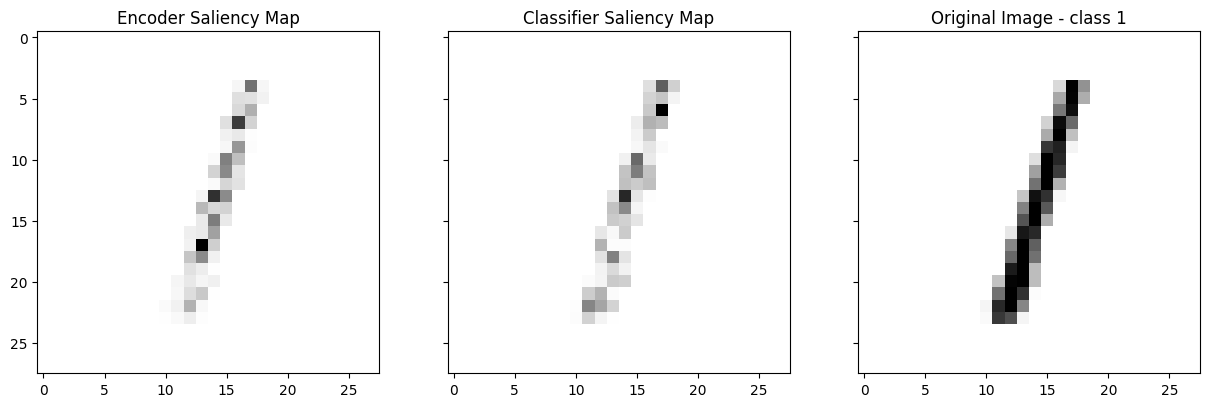

Text(0.5, 1.0, 'Original Image - class 1')

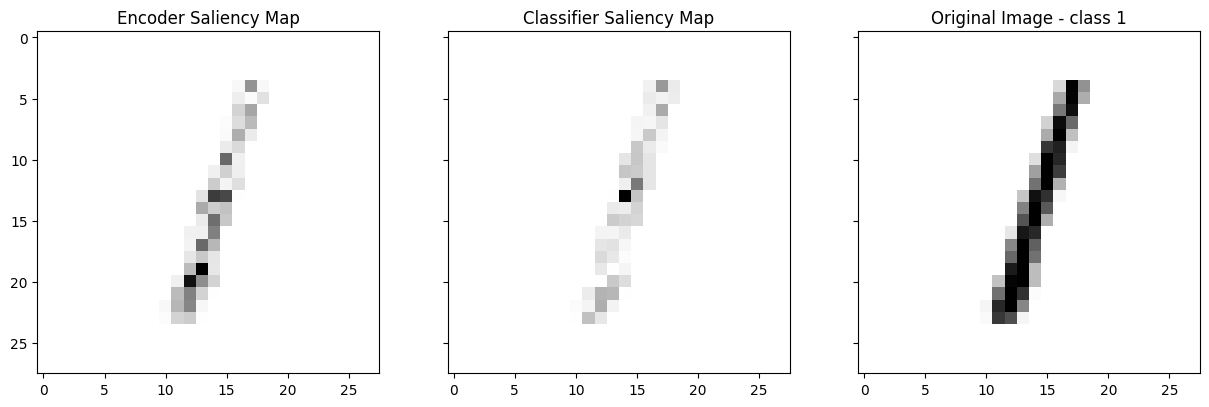

In [60]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=[15, 6])
ax[0].imshow(a_enc_i, cmap='gray_r')
ax[0].set_title('Encoder Saliency Map')

ax[1].imshow(a_full_i, cmap='gray_r')
ax[1].set_title('Classifier Saliency Map')

ax[2].imshow(X, cmap='gray_r')
ax[2].set_title(f'Original Image - class {y}')

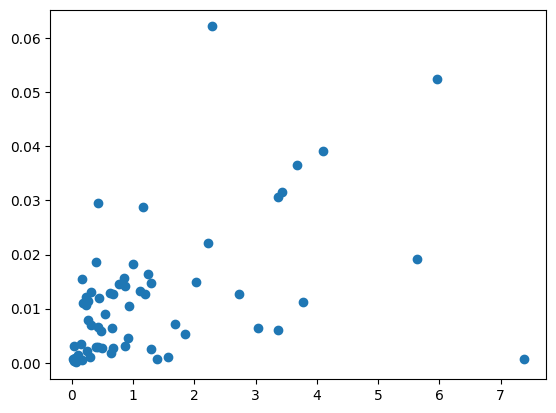

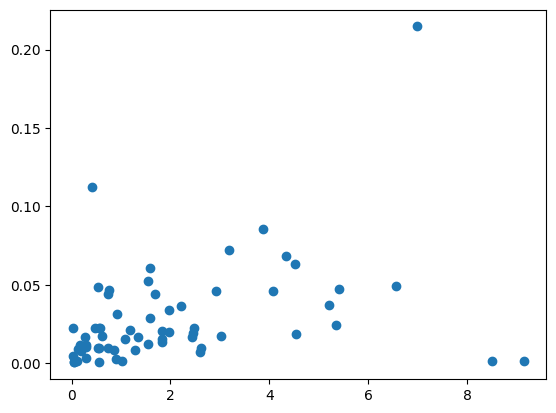

In [61]:
# Let's look for whether these are correlated acros s a _single_ image by visualising them as a scatter
plt.scatter(m_enc, m_full)

We have some satisfying answers:

1. Correlations appear much lower _within_ images than across images. Intuitively, if we take the mean across the images, the bits in the centre will all end up with some feature importance between 0 and 1. However, most explainability metrics are defined per prediction, and this can be important in e.g. regulatory contexts.

2. At least some of the correlation is driven by the fact that the black pixels have spuriously high correlations. Masking out these pixels makes a substantive difference.

TODO: we should check whether their pearson results change when masking out some pixels. We should also check whether their results are taken per image or somehow aggregating across images.

Now, we should make the above into a function that we can easily loop over a dataset, which should give us pearson correlations per image.

In [62]:
def image_pearson(i: int, dataset, encoder_attributions, full_attributions, mask_dead_pixels=True):
    X, y = dataset[i]
    X = X.squeeze()

    X = X.squeeze()
    a_enc_i = encoder_attributions[i].squeeze()
    a_full_i = full_attributions[i].squeeze()

    if mask_dead_pixels:
        mask = (X == 0)
        a_enc_i = a_enc_i[~mask]
        a_full_i = a_full_i[~mask]

    rho = np.corrcoef(a_enc_i.flatten(), a_full_i.flatten())[0, 1]

    return rho

rhos = []
for i in range(len(test_dataset)):
    rho = image_pearson(i, test_dataset, encoder_attributions, pipeline_attributions, mask_dead_pixels=True)
    rhos.append(rho)

rhos = np.array(rhos)


In [63]:
pd.Series(rhos).mean()**2

0.10627450704931021

0.10498016646395802

(array([  1.,   0.,   0.,   0.,   2.,   1.,   2.,  10.,  14.,  10.,  30.,
         48.,  60., 117., 180., 233., 287., 390., 448., 530., 659., 639.,
        681., 722., 681., 667., 584., 530., 490., 403., 322., 257., 223.,
        176., 147.,  93.,  85.,  63.,  56.,  44.,  37.,  24.,  21.,  10.,
         12.,   2.,   4.,   3.,   1.,   1.]),
 array([-0.22176058, -0.1991938 , -0.17662702, -0.15406023, -0.13149345,
        -0.10892667, -0.08635989, -0.06379311, -0.04122632, -0.01865954,
         0.00390724,  0.02647402,  0.04904081,  0.07160759,  0.09417437,
         0.11674115,  0.13930793,  0.16187472,  0.1844415 ,  0.20700828,
         0.22957506,  0.25214184,  0.27470863,  0.29727541,  0.31984219,
         0.34240897,  0.36497575,  0.38754254,  0.41010932,  0.4326761 ,
         0.45524288,  0.47780966,  0.50037645,  0.52294323,  0.54551001,
         0.56807679,  0.59064358,  0.61321036,  0.63577714,  0.65834392,
         0.6809107 ,  0.70347749,  0.72604427,  0.74861105,  0.77117783,
 

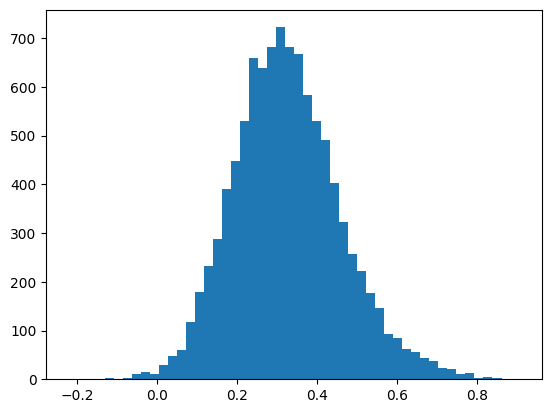

(array([  1.,   0.,   2.,   3.,   5.,  23.,  23.,  32.,  45.,  60.,  89.,
        129., 166., 221., 313., 371., 422., 468., 544., 573., 620., 659.,
        651., 609., 542., 574., 444., 465., 358., 295., 251., 214., 153.,
        133., 118.,  85.,  69.,  64.,  39.,  42.,  30.,  25.,  16.,   7.,
         13.,  12.,   7.,  10.,   4.,   1.]),
 array([-0.13913508, -0.11876024, -0.0983854 , -0.07801057, -0.05763573,
        -0.03726089, -0.01688606,  0.00348878,  0.02386362,  0.04423845,
         0.06461329,  0.08498813,  0.10536296,  0.1257378 ,  0.14611264,
         0.16648747,  0.18686231,  0.20723715,  0.22761198,  0.24798682,
         0.26836166,  0.28873649,  0.30911133,  0.32948617,  0.349861  ,
         0.37023584,  0.39061067,  0.41098551,  0.43136035,  0.45173518,
         0.47211002,  0.49248486,  0.51285969,  0.53323453,  0.55360937,
         0.5739842 ,  0.59435904,  0.61473388,  0.63510871,  0.65548355,
         0.67585839,  0.69623322,  0.71660806,  0.7369829 ,  0.75735773,
 

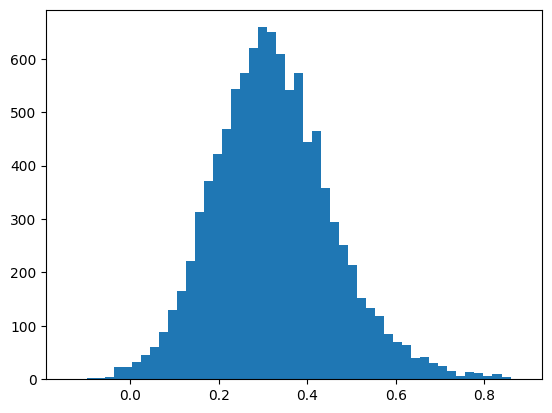

In [64]:
plt.hist(rhos, bins=50)

# Further extensions

Can we figure out what properties of the map make this happen? E.g. is it an issue of scale? To test this, we can look at properties of the decoder.

In [65]:
from lfxai.explanations.features import AuxiliaryFunction

In [66]:
decoder = copy.deepcopy(classifier.lin_output)

In [67]:
# Pass through once to get a baseline for the hidden
hiddens = []

for X,y in test_loader:
    hidden = encoder(X).detach().numpy()
    hiddens.append(hidden)


hiddens = np.concatenate(hiddens)
hidden_baseline = hiddens.mean(axis=0)
hidden_baseline = hidden_baseline[np.newaxis, ...]
hidden_baseline = torch.Tensor(hidden_baseline)

In [68]:
decoder_attributions = []
# hidden_baseline = torch.zeros(1, 4)

gradshap_decoder = GradientShap(decoder)

for X, y in test_loader:
    hidden = encoder(X)

    auxiliary_encoder = AuxiliaryFunction(decoder, hidden)
    gradshap_decoder.forward_func = auxiliary_encoder

    attr = gradshap_decoder.attribute(hidden, baselines=hidden_baseline)
    attr = attr.detach().cpu().numpy()

    decoder_attributions.append(attr)

decoder_attributions = np.concatenate(decoder_attributions)
decoder_attributions = np.abs(decoder_attributions)


In [69]:
df = pd.DataFrame(decoder_attributions)
df.describe()

,0,1,2,3
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,8.610293e-02,7.658649e-02,1.064320e-01,7.258721e-02
std,2.458374e-01,1.984536e-01,2.793012e-01,1.917648e-01
min,1.000415e-37,3.281716e-38,1.063662e-37,2.017328e-37
25%,7.125689e-06,7.067812e-06,9.303020e-06,6.271564e-06
50%,2.020602e-03,1.998566e-03,2.108718e-03,1.681972e-03
75%,4.581810e-02,4.354408e-02,5.387384e-02,3.897731e-02
max,3.152510e+00,2.362978e+00,4.114078e+00,2.538982e+00


,0,1,2,3
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,9.141238e-02,7.823709e-02,1.010593e-01,7.298534e-02
std,2.604473e-01,2.085514e-01,2.659156e-01,1.900639e-01
min,1.927218e-28,1.222128e-28,1.023821e-28,7.095506e-28
25%,6.527650e-06,6.781632e-06,8.801874e-06,6.462404e-06
50%,1.983251e-03,1.912684e-03,1.994122e-03,1.755910e-03
75%,4.684459e-02,4.346430e-02,5.216908e-02,3.797319e-02
max,3.025542e+00,3.723155e+00,2.943776e+00,2.398223e+00


### Now that we have obtained the decoder attributions, we need to hone in on a pixel that failed our test before and try and understand what went wrong.

Note: this ended up being a bit of a failure - it seems like the scale is indeed the key, but since the explanations are locally linear, this is a pretty trivial observation.

In [70]:

i = 0

X, y = test_dataset[i]
X = X.squeeze()
a_enc_i = encoder_attributions[i].squeeze()
a_full_i = pipeline_attributions[i].squeeze()
a_dec_i = decoder_attributions[i].squeeze()

#  Compute similarity in this image
(np.corrcoef(a_enc_i.flatten(), a_full_i.flatten()))

array([[1.        , 0.61266959],
       [0.61266959, 1.        ]])

array([[1.        , 0.68714732],
       [0.68714732, 1.        ]])

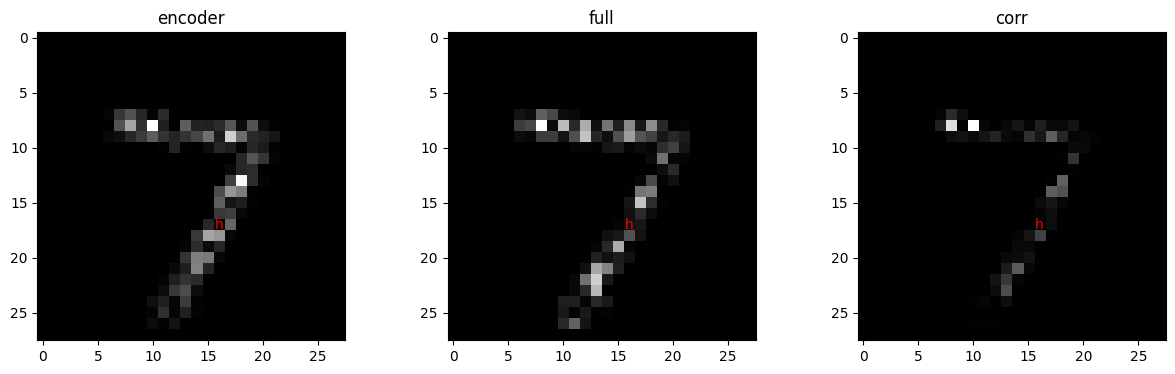

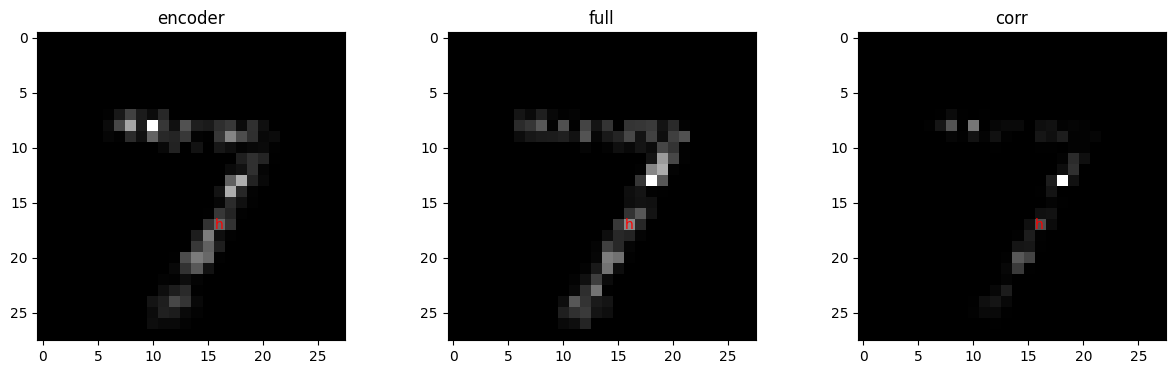

In [71]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
ax[0].imshow(a_enc_i, cmap='gray')
ax[0].set_title('encoder')

ax[1].imshow(a_full_i, cmap='gray')
ax[1].set_title('full')

ax[2].imshow(a_full_i*a_enc_i, cmap='gray')
ax[2].set_title('corr')

k, l = 16, 17
for i in range(len(ax)):
    ax[i].text(k, l, 'h', c='red', ha='center',va='center')

In [72]:
(a_full_i*a_enc_i)[k, l]

0.024462702

0.08099316

In [73]:
mask = X > 0

In [74]:
all_corrs = pd.Series((a_full_i*a_enc_i)[mask])
all_corrs = all_corrs.sort_values()

In [75]:
(all_corrs > (a_full_i*a_enc_i)[k, l]).sum()/len(all_corrs)

0.2413793103448276

0.1724137931034483

In [76]:
a_full_i[k, l]

0.009013363

0.04782805

In [77]:
a_enc_i[k, l]

2.7140481

1.6934239

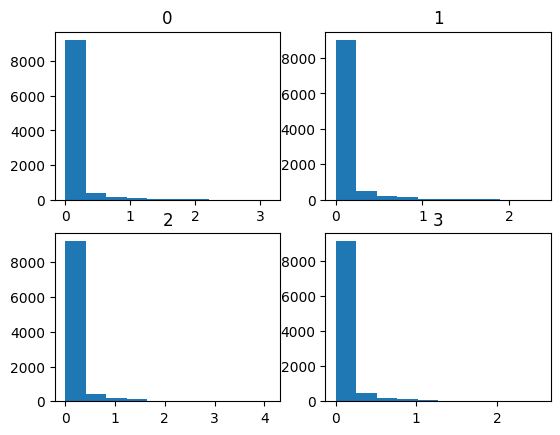

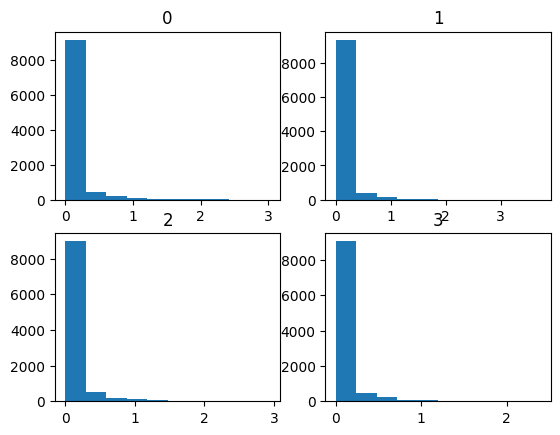

In [78]:
fig, ax = plt.subplots(2, 2)

for i in range(4):
    a = ax.flatten()[i]
    a.hist(df[i])
    a.set_title(i)

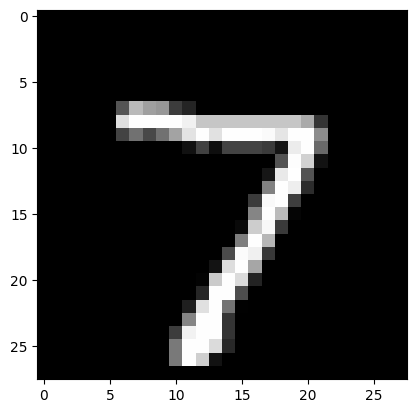

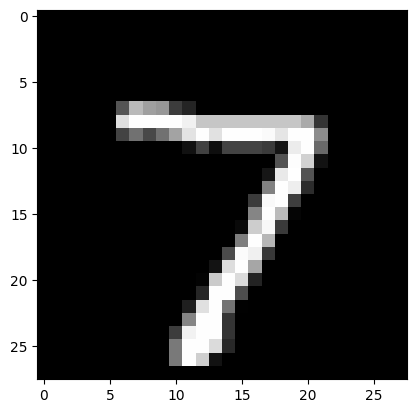

In [79]:
plt.imshow(X, cmap='gray')

In [80]:
a_dec_i

array([4.2865935e-07, 9.3821392e-08, 7.1863838e-08, 1.9529637e-07],
      dtype=float32)

array([1.35200302e-04, 1.10215144e-04, 9.04250483e-05, 6.08427354e-06],
      dtype=float32)